In [2]:
import pointCollection as pc
import matplotlib.pyplot as plt
import numpy as np
import glob
import h5py
import re
import pdb
import scipy.sparse as sp
%matplotlib widget 

# read the saved angle information

In [ ]:
spot_dir='/Volumes/ice3/ben/spot_angles/'
spots=range(1,7)
angles={spot:[] for spot in spots}
for file in glob.glob(spot_dir+'/*.h5'):
    for spot in spots:
        angles[spot] +=[pc.data().from_h5(file, group=f'spot_{spot}')]

for spot in spots:
    temp=pc.data().from_list(angles[spot])
    ind=np.argsort(temp.delta_time)
    temp=temp[ind]
    temp=temp.ravel_fields()
    good=np.argwhere(np.diff(temp.delta_time)>0).ravel()
    good = good[np.isfinite(temp.sin_coel[good])]
    print([temp.size,len(good)])
    angles[spot]=temp[good].ravel_fields()
    

### Plots of off-pointing coordinates over time:

In [ ]:
# back-of-the-envelope estimate of the range from ICESat-2 to the surface
R0=500e3

# calculate the x and y offsets as a function of delta_time (for plotting purposes only)
xydt={}
for spot in spots:
    xydt[spot] = pc.data().from_dict({'x':R0*angles[spot].sin_coel*angles[spot].cos_az,
                  'y':R0*angles[spot].sin_coel*angles[spot].sin_az,
                  'year':angles[spot].delta_time/24/3600/365.25+2018})


In [ ]:

hf, hax=plt.subplots(2,1, sharex=True)
for spot in [3, 4]:
    hax[0].plot(xydt[spot].year, xydt[spot].x,'.', label=f'spot {spot}')
    hax[1].plot(xydt[spot].year, xydt[spot].y,'.')

plt.sca(hax[0])
plt.legend()

hax[0].set_ylabel('along-track')
hax[1].set_ylabel('across-track')

for ax in hax:
    ax.set_ylim([-20000, 20000])
plt.tight_layout()

These plots show the x and y offsets (in along-track coordinates) of the central-pair spots.  The default plot is zoomed out to $\pm$ 20 km, showing (among other things) the off pointing strategy that's helping to fill in the pole hole.  It's surprising (to me) that in the early part of the mission (Q4 of 2018 -> Q1 of 2020), when IS2 was not pointing accurately at the RGTs, the along-track pointing was unremarkable.  

### Functions for reading in crossover data

In [ ]:
xover_base='/Volumes/ice3/ben/ATL06/xovers/Antarctic/r005'
# define all time values, in 10-day increments between 2018 and 2022
delta_t=10*24*3600
t_centers=np.arange(0.75*24*3600*365, (2022-2018)*24*3600*365, delta_t/2)

DEM_file='/Volumes/ice3/ben/from_i9/REMA/DEM_500m_filled/mosaic_500m_dem_filled.tif'
DEM=pc.grid.data().from_geotif(DEM_file, skip=10)


In [ ]:
def RDE(x):
    xs=x.copy()
    xs=np.isfinite(xs)   # this changes xs from values to a boolean
    if np.sum(xs)<2 :
        return np.nan
    ind=np.arange(0.5, np.sum(xs))
    LH=np.interp(np.array([0.16, 0.84])*np.sum(xs), ind, np.sort(x[xs]))
    #print('LH =',LH)
    return (LH[1]-LH[0])/2.  # trying to get some kind of a width of the data ~variance

def read_xovers(file, fields=None):
    '''
    Read crossovers from a saved crossover file
    
    Inputs :
    File (str): hdf-5 file to read
    fields (list of strs): fields to read from the file
    
    Returns:
    v (pc.data) field values interpolated to the crossover location
    d (pc.data) Differences between the interpolated field values 
    m (pc.data) Metadata fields for each crossover location, including grounded status, slope, and location
    data (list of pc.data objects) raw data read from each crossover file
    '''
    
    if fields is None:
        fields=['x','y','delta_time','h_li','h_li_sigma','h_mean','spot', 'rgt', 'dh_fit_dx','dh_fit_dy','atl06_quality_summary', 'latitude']
    
    m = pc.data().from_h5(file, field_dict={None:['grounded','x','y','slope_x','slope_y']})
    v=pc.data(columns=2)
    data = [pc.data(columns=2).from_h5(file, field_dict={group:fields+['W']}) for group in ['data_0','data_1']]

    
    # get ascending-vs-descending status
    asc=np.zeros([m.x.shape[0],2])
    for ii, data_i in enumerate(data):
        asc[:,ii] = data_i.latitude[:,1] > data_i.latitude[:,0]
    
    m.assign({'asc_minus_desc': (asc[:,0]==0) & (asc[:,1]==1)})
    m.assign({'desc_minus_asc': (asc[:,0]==1) & (asc[:,1]==0)})
    
    d=pc.data()
    for field in fields:
        if field=='W':
            continue
        temp = np.zeros((m.size, 2))
        for col in [0, 1]:
            temp[:, col] = np.sum(data[col].W * getattr(data[col], field), axis=1)
        
        if field in ['rgt','cycle','spot']:
            # integer fields:
            v.assign({ field : np.round(temp).astype(int)})
        else:
            v.assign({ field : temp})
            
        d.assign({ field : np.diff(temp, axis=1)})
    for item in [v, d]:
        item.__update_size_and_shape__()

    return v, d, m, data

def filter_xovers(v, d, m, data, 
                  slope_max = 0.2, grounded_tol = 0.99, 
                  asc_minus_desc=None, max_delta_t = None, 
                  min_h=None):
    '''
    Filter the crossovers based on field values
    '''

    good=np.all(v.atl06_quality_summary < 0.01, axis=1)
    for di in data:
        good &= np.abs(di.delta_time[:,1]-di.delta_time[:,0]) < 0.005
    good &= m.grounded > grounded_tol
    good &= np.all(np.abs(np.c_[v.dh_fit_dx, v.dh_fit_dy])< slope_max, axis=1)
    
    if asc_minus_desc is not None:
        good &= (m.asc_minus_desc == asc_minus_desc)
    else:
        good &= (m.asc_minus_desc | m.desc_minus_asc)
    if max_delta_t is not None:
        good &= (v.delta_t[:,1]-v.delta_t[:,0]) < max_delta_t
    if min_h is not None:
        min_h &= (np.all(v.h_li > min_h, axis=1))
    
    v.index(good)
    d.index(good)
    m.index(good)
    for di in data:
        di.index(good)


def collect_xovers_by_h(xover_base, bin_size=100e3, DEM=None, min_h=1500, 
                        min_r = 250e3,
                        asc_minus_desc=None, max_delta_t=24*3600*30, 
                        get_bins_only=False, get_data=False):
    tile_re=re.compile('E(.*)_N(.*).h5')
        
    pad_0=np.arange(-bin_size/2, bin_size/2*1.25, bin_size/4)
    x_pad, y_pad = np.meshgrid(pad_0, pad_0)
    v, d, m, D0, D1 = [[], [], [], [], []]
    files=glob.glob(xover_base+f'/c*/E*.h5')
    print(len(files))
    xys=[]
    for file in files:
        try:
            xy=np.c_[[int(xx) for xx in tile_re.search(file).groups()]]
            zz = DEM.interp(xy[0]+x_pad.ravel(), xy[1]+y_pad.ravel())
            zz[~np.isfinite(zz)]=0
            if np.any(zz < min_h):
                continue
            if min_r is not None:
                if np.any(np.sqrt((xy[0]+x_pad.ravel())**2+ (xy[1]+y_pad.ravel())**2)<min_r):
                    continue
            xys += [xy]
            if get_bins_only:
                continue
            vv, dd, mm, DD = read_xovers(file)
            filter_xovers(vv, dd, mm, DD, asc_minus_desc=asc_minus_desc, min_h=min_h)

            v += [vv]
            d += [dd]
            m += [mm]
            if get_data:
                D0 += [DD[0]]
                D1 += [DD[1]]
        except Exception as e:
            print(e)
            pass
    if get_bins_only:
        return xys
    v=pc.data(columns=2).from_list(v)
    d=pc.data().from_list(d)
    m=pc.data().from_list(m)
    if get_data:
        D0=pc.data(columns=2).from_list(D0)
        D1=pc.data(columns=2).from_list(D1)
        return v, d, m, D0, D1
    else:
        return v, d, m


In [ ]:
xys=collect_xovers_by_h(xover_base, DEM=DEM, max_delta_t = 7*24*3600, min_r=300e3, min_h=2500, get_bins_only=True)
 
xys=np.r_[xys][:,:,0];
plt.figure(); 
DEM.show(gradient=True)
plt.imshow(DEM.z > 2500, cmap='Blues', extent=DEM.extent, origin='lower', alpha=0.25)
plt.plot(xys[:,0], xys[:,1],'r.')

## Read in the crossovers

In [ ]:
v, d, m = collect_xovers_by_h(xover_base, DEM=DEM, max_delta_t = 7*24*3600, min_r=300e3, min_h=2500)


In [ ]:
xyi = np.unique(np.round((v.x[:,0]+1j*v.y[:,0])/1000))
plt.figure()
plt.plot(np.real(xyi), np.imag(xyi),'.')

In [ ]:
v.size

In [ ]:
#if True:  
#    v, d, m = collect_xovers_by_h(xy, 8.e5, np.arange(1, 14), xover_base, max_delta_t = 5*24*3600)

if True:
    temp={field:np.zeros_like(v.delta_time) for field in angles[1].fields}
    for spot, ang in angles.items():
        for col in [0, 1]:
            these=np.argwhere(v.spot[:,col]==spot)
            for field in ang.fields:
                temp[field][these,col]=np.interp(v.delta_time[these,col], ang.delta_time, getattr(ang, field))
    v.assign(temp)
    for field in ang.fields:
        temp=getattr(v, field)
        d.assign({field:temp[:,1]-temp[:,0]})

    H_IS = 6859.07*1.e3 + 9000 # nearly circular, add 9 km to match Scott's calculation 511 km at the poles
    R_WGS84=6356752.314  # semi-minor axis
    
    # calculate spot geometry
    H0=H_IS - (R_WGS84 + v.h_li)
    rho = H0*v.sin_coel/v.cos_coel
    v.assign({'x_sp':rho*v.cos_az,
              'y_sp':rho*v.sin_az})
    d.assign({'x_sp':v.x_sp[:,1]-v.x_sp[:,0], 
             'y_sp':v.y_sp[:,1]-v.y_sp[:,0]})


In [ ]:
large_offsets = np.any(np.abs(v.x_sp)>8000, axis=1) | np.any(np.abs(v.y_sp) > 1000, axis=1)
large_offset_data = {'v': v[large_offsets],'d':d[large_offsets], 'm':m[large_offsets]}

# remove crossovers containing really large off-nadir offsets
good = np.all(np.abs(v.x_sp) < 8000, axis=1) & np.all(np.abs(v.y_sp) < 5000, axis=1)
print(np.mean(good))
v.index(good)
d.index(good)
m.index(good)

In [ ]:
def calc_biases_perspot(d, v, ind=None, field='h_li', b_est=None, max_iterations=20):
    '''
    Calculate per-rgt and per-spot biases based on a set of crossover data
    Inputs:
        d (pc.data) Differences between the interpolated field values 
        v (pc.data) field values interpolated to the crossover location
        ind (numpy array): (optional) indices of crossovers that should be included in the calculation
        field: (optional) height field to use (default is h_li)
        b_est : (optional) estimated bias for the crossovers in 'ind'
        Note the d and v are assumed to represent crossovers  either (1) within a single cycle or (2)
        for short enough time periods that there will not be two different passes with the same RGT number
        
    Returns:
        b_spot (numpy array) : Estimated bias for each spot (first entry corresponds to spot 1, etc)
        b_rgt (numpy array) : Estimated bias for each rgt (first entry corresponds to rgt 1, etc)
        bias_est_spot (numpy array) : estimated bias due to spot biases for each data point 
                                    (includes those in the 'ind' variable)
        bias_est_rgt (numpy array) : estimated bias due to rgt bias for each data point 
                                    (includes those in the 'ind' variable)
        sigma_hat (float) : robust misfit between the height differences and the bias model
        sigma_corr (float) : standard devlation between height and the full (rgt and spot) bias model
        sigma_unc (float) : standard deviation between height and the rgt-only bias model
        sigma_data (float) : standard deviation of raw, edited data
        N_spot (numpy array) : Number of data contributing to the estimate for each spot
        N_rgt (numpy array) : Number of data contributing to the estimate for each rgt.
        t_range (iterable) : first and last delta_t included in the calculation
        fit_index (iterable) : data points included in the fit (after editing)
    '''
    
    # select the data to process
    if ind is None:
        v1=v.copy()
        d1=d.copy()
        ind = np.arange(len(d.delta_time), dtype=int)
    else:
        v1=v[ind]
        d1=d[ind]
    if b_est is not None:
        setattr(d1, field, getattr(d1, field)-b_est)

    #Make indexes for unique spot and rgt values
    uS, iS=np.unique(v1.spot, return_inverse=True)
    uT, iT=np.unique(v1.rgt,  return_inverse=True)
    row=np.arange(v1.shape[0])
    # make a matrix that calculates the bias for each data point when multiplied by a set of spot biases
    G_sp=sp.coo_matrix((np.c_[-np.ones(v1.shape[0]), np.ones(v1.shape[0])].ravel(),(np.c_[row, row].ravel(), iS.ravel())))
    # make a matrix that calculates the bias for each data point when multiplied by a set of rgt biases
    G_rgt=sp.coo_matrix((np.c_[-np.ones(v1.shape[0]), np.ones(v1.shape[0])].ravel(),(np.c_[row, row].ravel(), iT.ravel())))
    # make a constraint matrix for the mean of all spot biases
    G_sp_mean=sp.coo_matrix((np.r_[np.ones(len(uS)), np.zeros(len(uT))],
                              (np.zeros(len(uS)+len(uT), dtype=int), 
                                np.arange(len(uS)+len(uT), dtype=int)))) 
    # make a constraint matrix for the mean of all rgt biases
    G_rgt_mean=sp.coo_matrix((np.r_[np.zeros(len(uS)), np.ones(len(uT))],
                              (np.zeros(len(uS)+len(uT), dtype=int), 
                                np.arange(len(uS)+len(uT), dtype=int)))) 

    # put all the matrices together into one sparse matrix
    G=sp.vstack([sp.hstack([G_sp, G_rgt]), G_sp_mean, G_rgt_mean, 0.0001*sp.eye(len(uS)+len(uT))])
    G=G.tocsr()
    #make a data vector of height (h_li) differences
    data=np.r_[getattr(d1, field).ravel(), np.zeros(G.shape[0]-d1.shape[0])]
    r=np.zeros(d1.shape[0])
    good=np.ones(G.shape[0], dtype=bool)
    # initialize book-keeping variables
    last_good=np.zeros_like(good)
    sigma=1.e4
    n_data=d1.shape[0]
    count = 0
    # iterate to remove outliers
    while np.sum(np.logical_xor(good,last_good))>0 and (count < max_iterations):
        count += 1
        ii=np.flatnonzero(good)
        mm=sp.linalg.spsolve(G[ii,:].T.dot(G[ii,:]), G[ii,:].T.dot(data[ii]))
        r=getattr(d1, field).ravel()-G[0:d1.size,:].dot(mm)
        sigma_hat=RDE(r[ii[ii<n_data]])
        last_good=good
        good=np.ones(G.shape[0], dtype=bool)
        good[np.argwhere(np.abs(r)>np.maximum(0.05, 3*sigma_hat))]=False
    # note: at the end of this loop, ii will reflect the elements used in the fit 
    # (good will be one step forward, but will not reflect the current mm)
    r_temp=r[ii[ii<n_data]]
    fit_index = ind[ii[ii<n_data]]
    # estimate the variance in the corrected data (including the full corrections in h_li)
    sigma_corr = np.sqrt(np.sum(r_temp**2)/(len(r_temp)-G.shape[1]))
    
    # calculate the rgt-only component of the biases
    m_uncorr = mm.copy()
    m_uncorr[0:len(uS)]=0
    bias_est_rgt = G[0:d1.size,:].dot(m_uncorr)
    r_uncorr = getattr(d1, field).ravel()- bias_est_rgt
    r_temp=r_uncorr[ii[ii<n_data]]
    sigma_uncorr = np.sqrt(np.sum(r_temp**2)/(len(r_temp)-G.shape[1]))
    sigma_data = np.std(getattr(d1, field)[ii[ii<n_data]])
    
    # calculate the spot-only component of the biases
    m_spot = mm.copy()
    m_spot[len(uS):]=0
    bias_est_spot = G[0:d1.size,:].dot(m_spot)
    
    # map the solution to the output variables
    # one b_spot and n_spot for each spot
    b_spot=np.zeros(6)+np.NaN
    N_spot=np.zeros(6)
    
    for ind,spot in enumerate(uS):
        b_spot[int(spot)-1]=mm[ind]
        N_spot[int(spot)-1]=np.sum(np.abs(G[:,spot][ii]))-1
    # one b_rgt and N_rgt for each rgt
    b_rgt = np.zeros(1387)+np.NaN
    N_rgt = np.zeros(1387)+np.NaN
    for ind, rgt in enumerate(uT):
        b_rgt[int(rgt)-1]=mm[len(uS)+ind]
        N_rgt[int(rgt)-1]=np.sum(np.abs(G[:,len(uS)+ind][ii]))-1 
    return {'b_spot':b_spot, 
            'b_rgt':b_rgt, 
            'est_bias_rgt': bias_est_rgt,
            'est_bias_spot': bias_est_spot,
            'sigma_hat':sigma_hat, 
            'sigma_corr':sigma_corr, 
            'sigma_uncorr':sigma_uncorr,
            'sigma_data':sigma_data,
            'N_spot':N_spot, 
            'N_rgt':N_rgt,
            't_range': [np.min(v1.delta_time), np.max(v1.delta_time)], 
            'fit_index': fit_index}

### sketch solution for a correction for spot locations and height errors:

$$ 
    h = h_{sat} + R(\hat{b}\cdot\hat{z})
$$
where $h_{sat}$ is the height of the satellite, $\hat{b}$ is the beam vector, and $\hat{z}$ is the local vertical.

In terms of the x any y components of the beam vector, $\mathbf{b}$:
$$
    h = h_{sat} - (R^2 - b_x^2 - b_y^2)^{1/2}
$$
taking derivatives WRT $b_x$ and $b_y$, the displacements on the ground between the spot geolocations and nadir:
$$
    dh/db_j = \frac{b_j}{h_{sat}-h}
$$
so the error in any beam height is:
$$
    e_h \approx e_x \frac{b_x}{h_{sat}-h} + e_y \frac{b_y}{h_{sat}-h}
$$
where $e_x$ and $e_y$ are the components of the geolocation error vector.

The difference in heights between two spots ($ie.$ a crossover error) is then:
$$
    e_{h1}-e_{h0} = e_x \frac{b_{x1}-b_{x0}}{h_{sat}-h} +e_y \frac{b_{y1}-b_{y0}}{h_{sat}-h}
$$
We can collect the components of this equation for each 10-day period, and calculate a least-squares solution for $e_x$ and $e_y$ based on measured $h_1-h_0$.  $b_x$,  $b_y$ and $h$ are straightforward to calculate from variables on ATL06, and $h_{sat}$ can be derived from WGS84 and the ICESat-2 orbit.

In [ ]:
def calc_biases_xy(d, v, h_sat, ind=None, field='h_li', b_est=None, max_iterations=20):
    '''
    Calculate per-rgt and per-spot biases based on a set of crossover data
    Inputs:
        d (pc.data) Differences between the interpolated field values 
        v (pc.data) field values interpolated to the crossover location
        h_sat (numeric) : estimated height of the satellite above the reference surface
        ind (numpy array): (optional) indices of crossovers that should be included in the calculation
        field (string): (optinal) field for which to calculate the height differences
        b_est : (optional) estimated bias for the crossovers in 'ind'
        Note the d and v are assumed to represent crossovers within a single cycle
    Returns:
        b_spot (numpy array) : Estimated bias for each spot (first entry corresponds to spot 1, etc)
        b_rgt (numpy array) : Estimated bias for each rgt (first entry corresponds to rgt 1, etc)
        est_bias_xy (numpy array) : estimated bias due to xy offsets for each data point 
                                    (includes those in the 'ind' variable)
        est_bias_rgt (numpy array) : estimated bias due to rgt bias for each data point 
                                    (includes those in the 'ind' variable)
        sigma_hat (float) : robust misfit between the height differences and the bias model
        sigma_corr (float) : standard devlation between height and the full (rgt and xy) bias model
        sigma_uncorr (float) : standard devlation between height and the rgt-only  bias model
        sigma_data (float) : standard deviation of raw, edited data
        N_spot (numpy array) : Number of data contributing to the estimate for each spot
        N_rgt (numpy array) : Number of data contributing to the estimate for each rgt.
        x_spot, y_spot (numpy arrays): mean spot locations
        t_range: first and last times included in the solution
        fit_index (iterable) : data points included in the fit (after editing)
    '''
    
    if ind is None:
        v1=v.copy()
        d1=d.copy()
        ind = np.arange(len(d.delta_time), dtype=int)
    else:
        # select the data to process
        v1=v[ind]
        d1=d[ind]
    if b_est is not None:
        setattr(d1, field, getattr(d1, field)-b_est)

    uT, iT=np.unique(v1.rgt,  return_inverse=True)
    row=np.arange(v1.shape[0], dtype=int)
    # The first column calculates the x-bias difference
    G_x=((v1.x_sp[:,1]-v1.x_sp[:,0])/(h_sat-np.mean(v1.h_li, axis=1)))[:, None]
    G_y=((v1.y_sp[:,1]-v1.y_sp[:,0])/(h_sat-np.mean(v1.h_li, axis=1)))[:, None]
    # make a matrix that calculates the bias for each data point when multiplied by a set of rgt biases
    G_rgt=sp.coo_matrix((np.c_[-np.ones(v1.shape[0]), np.ones(v1.shape[0])].ravel(),(np.c_[row, row].ravel(), iT.ravel())))
    # make a constraint matrix for the mean of all rgt biases
    G_rgt_mean=sp.coo_matrix((np.r_[np.zeros(2), np.ones(len(uT))],
                              (np.zeros(2+len(uT), dtype=int), 
                                np.arange(2+len(uT), dtype=int)))) 

    # put all the matrices together into one sparse matrix
    G=sp.vstack([sp.hstack([G_x, G_y, G_rgt]), G_rgt_mean, 0.0001*sp.eye(2+len(uT))])
    G=G.tocsr()
    #make a data vector of height (h_li) differences
    data=np.r_[getattr(d1, field).ravel(), np.zeros(G.shape[0]-d1.shape[0])]
    r=np.zeros(d1.shape[0])
    good=np.ones(G.shape[0], dtype=bool)
    # initialize book-keeping variables
    last_good=np.zeros_like(good)
    sigma=1.e4
    n_data=d1.shape[0]
    count = 0
    # iterate to remove outliers
    while np.sum(np.logical_xor(good,last_good))>0 and (count < max_iterations):
        count += 1
        ii=np.flatnonzero(good)
        mm=sp.linalg.spsolve(G[ii,:].T.dot(G[ii,:]), G[ii,:].T.dot(data[ii]))
        r=getattr(d1, field).ravel()-G[0:d1.size,:].dot(mm)
        sigma_hat=RDE(r[ii[ii<n_data]])
        last_good=good
        good=np.ones(G.shape[0], dtype=bool)
        good[np.argwhere(np.abs(r)>np.maximum(0.05, 3*sigma_hat))]=False
    
    r_temp=r[ii[ii<n_data]]
    # estimate the variance in the corrected data (including the full corrections in h_li)
    sigma_corr = np.sqrt(np.sum(r_temp**2)/(len(r_temp)-G.shape[1]))
    
    # calculate the rgt biases and their stats
    m_uncorr = mm.copy()
    m_uncorr[0:2]=0
    bias_est_rgt = G[0:d1.size,:].dot(m_uncorr)
    r_uncorr = getattr(d1, field).ravel()-bias_est_rgt
    r_temp=r_uncorr[ii[ii<n_data]]
    sigma_uncorr = np.sqrt(np.sum(r_temp**2)/(len(r_temp)-G.shape[1]))
    sigma_data = np.std(getattr(d1, field)[ii[ii<n_data]])

    # estimate the xy component of the biases
    m_xy = mm.copy()
    m_xy[2:]=0
    bias_est_xy = G[0:d1.size,:].dot(m_xy)
    
    fit_index = ind[ii[ii<n_data]]

    
    # map the solution to the output variables
    N_spot=np.zeros(6)
    
    b_x = mm[0]
    b_y = mm[1]
    # one b_rgt and N_rgt for each rgt
    b_rgt = np.zeros(1387)+np.NaN
    N_rgt = np.zeros(1387)+np.NaN
    for ind, rgt in enumerate(uT):
        b_rgt[int(rgt)-1]=mm[2+ind]
        N_rgt[int(rgt)-1]=np.sum(np.abs(G[:,2+ind][ii]))-1
    x_spot=[np.median(v1.x_sp[v1.spot==spot]) for spot in range(1,7)]
    y_spot=[np.median(v1.y_sp[v1.spot==spot]) for spot in range(1,7)]
    
        
    return {'b_x':b_x, 
            'b_y':b_y, 
            'b_rgt':b_rgt, 
            'bias_est_xy' : bias_est_xy,
            'bias_est_rgt' : bias_est_rgt,
            'sigma_hat':sigma_hat, 
            'sigma_corr':sigma_corr, 
            'sigma_uncorr':sigma_uncorr,
            'sigma_data':sigma_data,
            'N_rgt':N_rgt, 
            'x_spot':x_spot, 
            'y_spot':y_spot,
            't_range': [np.min(v1.delta_time), np.max(v1.delta_time)], 
            'fit_index': fit_index}


### Bin the crossovers

The crossovers are already limited to $t_1-t_0$ < 7 days.  Bin the crossovers in time by the mean of the first and last times, with one bin every 3 days.  The minimum and maximum times included in the differences in any one bin should range from $t_{ctr}-5d$ to $t_{ctr}+5d$.

In [ ]:

ctr_t_tol = 6*24*3600

uT, t_bins = pc.unique_by_rows(np.round(np.mean(v.delta_time, axis=1)/ctr_t_tol)*ctr_t_tol, return_dict=True)


### Calculate the biases
There is no h_satellite parameter on ATL06, so we'll approximate it based on polar WGS84 (the semi-minor axis) and the ICESat-2 orbit radius (close enough to circular).

In [ ]:
H_IS = 6859.07*1.e3 + 9000  # apogee (but the orbit is nearly circular) Add 9 km to get 511 km HAE
R_WGS84=6356752.314  # semi-minor axis

out_spot=[]
out_xy=[]
out_spot_residual = []
bin_t_tol = 15*24*3600
count=-1
for this_t, ind in t_bins.items():
    count +=1
    ind_sub = ind[np.all(np.abs(v.delta_time[ind,:]-this_t) < bin_t_tol/2, axis=1)]
    if len(ind_sub) < 100:
        continue
    # preliminary fit: iterate both solutions to find common elements
    prelim_xy = calc_biases_xy(d, v, H_IS-R_WGS84, ind=ind_sub, max_iterations=20)
    prelim_spot = calc_biases_perspot(d, v, ind=ind_sub, max_iterations=20)
    final_ind = np.intersect1d(prelim_xy['fit_index'], prelim_spot['fit_index'])
    # final fit: run one iteration with the common elements of the two solutions
    out_xy += [calc_biases_xy(d, v, H_IS-R_WGS84, ind=final_ind, max_iterations=1)]
    out_spot += [calc_biases_perspot(d, v, ind=final_ind, max_iterations=1)]
    out_spot_residual += [calc_biases_perspot(d, v, ind=final_ind, b_est = out_xy[-1]['bias_est_xy'], max_iterations=1)]
    if np.mod(count, 50)==0:
        print(f'{count} out of {len(t_bins)}')


In [ ]:
spot_biases=np.c_[[oi['b_spot'] for oi in out_spot]]
residual_spot_biases = np.c_[[oi['b_spot'] for oi in out_spot_residual]]
x_biases = np.c_[[oi['b_x'] for oi in out_xy]]
y_biases = np.c_[[oi['b_y'] for oi in out_xy]]
xy_times = np.c_[[np.mean(oi['t_range']) for oi in out_xy]]
xy_R2 = np.c_[[(oi['sigma_corr']/oi['sigma_uncorr'])**2 for oi in out_xy]]
sp_R2 = np.c_[[(oi['sigma_corr']/oi['sigma_uncorr'])**2 for oi in out_spot]]
x_spot = np.c_[[oi['x_spot'] for oi in out_xy]]
y_spot = np.c_[[oi['y_spot'] for oi in out_xy]]

xy_sigma_u = np.c_[[oi['sigma_uncorr'] for oi in out_xy]]
sp_sigma_u = np.c_[[oi['sigma_uncorr'] for oi in out_spot]]
xy_sigma_c = np.c_[[oi['sigma_corr'] for oi in out_xy]]
sp_sigma_c = np.c_[[oi['sigma_corr'] for oi in out_spot]]
sp_sigma_d = np.c_[[oi['sigma_data'] for oi in out_spot]]
xy_sigma_d = np.c_[[oi['sigma_data'] for oi in out_xy]]

### Sample spot layout:

In [ ]:
plt.figure()
colors={1: 'crimson', 2:'hotpink', 3:'green', 4:'limegreen', 5:'dodgerblue', 6:'turquoise' }
for spot in range(1, 7):
    plt.plot(x_spot[100,spot-1], y_spot[100,spot-1],'*', color=colors[spot])
plt.gca().set_aspect(1);
plt.gca().set_xlabel('$x_{atc}$, m');
plt.gca().set_ylabel('$y_{atc}$, m');

In [ ]:
hf, hax = plt.subplots(2,1, figsize=[6,8])
for spot in range(1,7):
    hax[0].plot(2018+xy_times/24/3600/365.25, spot_biases[:, spot-1], color=colors[spot])
hax[0].set_xlabel('year')
hax[0].set_ylabel('vertical bias')
hax[0].set_title('per-spot biases')
  
plt.sca(hax[1])
plt.plot(2018+xy_times/24/3600/365.25, x_biases, label='along-track bias')
plt.plot(2018+xy_times/24/3600/365.25, y_biases, label='across-track bias')
plt.gca().set_xlabel('year')
plt.gca().set_ylabel('horizontal bias, m')
plt.gca().set_title('xy biases')
plt.legend()


### Spot biases estimated from the spot pattern and xy biases:
To get a sense of the correspondence between the two ways of looking at the spot biases, we can use the estimated spot xy offsets to predict the average spot biases.  The results are very similar.


In [ ]:
H_IS = 6859.07*1.e3+9000  # apogee (but the orbit is nearly circular).  Add 9 km to match 511 km HAE at S pole
H_surf=6356752.314 +2000 # semi-minor axis, on the plateau

R0 = H_IS-H_surf
plt.figure()
for spot in range(1, 7):
    E_h = x_biases.ravel()*x_spot[:, spot-1].ravel()/R0+ y_biases.ravel()*y_spot[:, spot-1].ravel()/R0
    plt.plot(2018+xy_times/24/3600/365.25, E_h, color=colors[spot])
    plt.plot(2018+xy_times/24/3600/365.25, spot_biases[:, spot-1], '.', color=colors[spot])

plt.gca().set_xlabel('year');
plt.gca().set_ylabel('vertical bias, m');
plt.gca().set_title('dots: independent vertical biases\nlines: vertical biases predicted from horizontal')
    

#### Spot biases that remain after the xy model is fit:

In [ ]:
hf, hax = plt.subplots(2,1, figsize=[6,8], sharex=True, sharey=True)
for spot in range(1,7):
    hax[0].plot(2018+xy_times/24/3600/365.25, spot_biases[:, spot-1], color=colors[spot])
hax[0].set_xlabel('year')
hax[0].set_ylabel('vertical bias')
hax[0].set_title('per-spot biases before xy correction')

for spot in range(1,7):
    hax[1].plot(2018+xy_times/24/3600/365.25, residual_spot_biases[:, spot-1], color=colors[spot])
hax[1].set_xlabel('year')
hax[1].set_ylabel('vertical bias')
hax[1].set_title('per-spot biases after xy correction')


  

In [ ]:
[np.nanstd(spot_biases), np.nanstd(residual_spot_biases), 1-np.nanstd(residual_spot_biases)**2/np.nanstd(spot_biases)**2]

## Plot the variance explained by each bias model

For each time step, we have solved for one bias associated with each RGT, and for the spot or xy-based bias model.  In these plots, we compare the magnitude of the residuals to the RGT-only bias model to the magnitude of the residuals associated with the spot- and xy-bias models.

At times, both models seem to explain a substantial fraction of the crossover variance.  There are times when the per-spot biases explain more variance, and times when the horizontal offsets explain more.  I need to think more about why the per-spot biases would explain less variance than the horizontal-offset model, but it may have to do with the mean-bias constraint, or with the rate of change of the biases.

In [ ]:
hf, hax = plt.subplots(2,1, figsize=[6, 8]) 

hax[0].plot(xy_times/24/3600/365.25+2018, xy_sigma_d,'k.', label='data uncorrected')

hax[0].plot(xy_times/24/3600/365.25+2018, xy_sigma_u,'g:', label='xy: rgt')
hax[0].plot(xy_times/24/3600/365.25+2018, xy_sigma_c,'g', label='xy: rgt,xy')

hax[0].plot(xy_times/24/3600/365.25+2018, sp_sigma_u,'r:', label='per-spot: rgt')
hax[0].plot(xy_times/24/3600/365.25+2018, sp_sigma_c,'r', label='per-spot: rgt,sp')
plt.sca(hax[0])
plt.legend()
hax[0].set_ylabel('residual std, m')


hax[1].plot(xy_times/24/3600/365.25+2018, 100-xy_R2*100,'g', label='xy bias')
hax[1].plot(xy_times/24/3600/365.25+2018, 100-sp_R2*100,'r', label='per-spot bias')
hax[1].set_ylabel('% of residual variance explained')
plt.sca(hax[1])
plt.legend()

### Export spot biases as a csv

In [ ]:
spots=range(1,7)

import pandas as pd
temp={'delta_time': xy_times}
temp.update({'x_bias':x_biases,'y_bias':y_biases})

for spot in range(1,7):
    temp.update({f'spot_{spot}_bias':spot_biases[:,spot_i] for spot_i, spot in enumerate(spots)})
for spot in range(1,7):
    temp.update({f'spot_{spot}_bias_xycorr':residual_spot_biases[:,spot_i] for spot_i, spot in enumerate(spots)})
temp.update({'total_sigma':xy_sigma_d,
            'rgt_corr_sigma':xy_sigma_u, 
            'spot_corr_sigma':sp_sigma_c,
            'xy_corr_sigma':xy_sigma_c})
for field in temp:
    temp[field]=temp[field].ravel()
df=pd.DataFrame(temp)
df.to_csv('spot_and_xy_biases_rel005_plateau_6day.csv', index=False)
! pwd

In [ ]:
xy_tr = np.c_[[oi['t_range'] for oi in out_xy]]
xy_N = np.c_[[len(oi['bias_est_xy']) for oi in out_xy]]
plt.figure(figsize=[6,4]); 
plt.plot((xy_tr[:,1]-xy_tr[:,0])/24/3600)
plt.title('days in each solution (max-min)')
plt.figure(figsize=[6,4]); 
plt.plot(xy_N)
plt.title('N data in each solution')

In [ ]:
370*25000

## Use the relationship between slope and crossover variance to estimate the crossover error


### Formula:
$$
dh = m * \varepsilon_{xy} + \sigma_0
$$

$$
    dh^2 = m^2 \varepsilon_{xy}^2 + 2 m \varepsilon_{xy} \sigma_0 + \sigma_0^2
$$

assume m is zero-mean

$$
    var(dh) = m^2 \sigma_{xy}^2 + \sigma_0^2
$$

In [ ]:
def est_pointing_error(v, d, ind0,  delta_slope, N_min=20, max_slope=0.2):
    v_sub=v[ind0]
    d_sub=d[ind0]
    slope_mag=np.sqrt(v_sub.dh_fit_dx**2+v_sub.dh_fit_dy**2)
    good=np.abs(slope_mag[:,1]-slope_mag[:,0])< delta_slope
    v_sub=v_sub[good]
    d_sub=d_sub[good]
    slope_mag=np.mean(slope_mag[good,:], axis=1)
    
    uS, sl_ind = pc.unique_by_rows(np.round(slope_mag/delta_slope)*delta_slope, return_dict=True)
    sl_med=[]
    var=[]
    N=[]
    for sl, ii in sl_ind.items():
        sl_med += [np.median(slope_mag[ii])]
        sigma_hat=RDE(d_sub.h_li[ii])
        ii1=ii[np.abs(d_sub.h_li[ii])<3*sigma_hat]
        var += [np.mean(d_sub.h_li[ii1]**2)]
        N += [len(ii1)]

    sl_med=np.array(sl_med)
    var=np.array(var)
    N=np.array(N)
    
    these = (N>N_min) & (sl_med > 0.005)
    
    G=np.c_[sl_med[these]**2, np.ones_like(sl_med[these])]
    m=sp.linalg.spsolve(G.T.dot(G), G.T.dot(var[these]))
    sigma_xy=np.sqrt(m[0])
    sigma_0 = np.sqrt(m[1])
    return sigma_xy, sigma_0,  sl_med[N>N_min], var[N>N_min], N[N>N_min]

In [ ]:
#sl_med, var, N = est_pointing_error(v, d, np.concatenate([bb['fit_index'] for bb in out_xy[100:110]], axis=0),  0.005, N_mim =50)
#np.sum(N)

#keys=list(t_bins.keys())
#sigma_xy=np.zeros(len(keys)-5)
#sigma_0=np.zeros(len(keys)-5)
t_of_sigma=np.zeros(len(keys)-5)

for count in np.arange(0, len(keys)-5):
    
#    these=np.concatenate([t_bins[key] for key in keys[count:count+5]], axis=0)
#    sigma_xy[count], sigma_0[count], sl_med, var, N = est_pointing_error(v, d, these, delta_slope=0.005)
    t_of_sigma[count] =np.mean(keys[count:count+5])
#plt.figure(); plt.plot(sl_med, N)

In [ ]:
plt.figure(); 
plt.plot(t_of_sigma/24/3600/365.25 +2018, sigma_xy, label='geolocation error')
#plt.plot(2018+xy_times/24/3600/365.25, np.sqrt(x_biases**2+y_biases**2), label='bias_mag')
plt.plot(2018+xy_times/24/3600/365.25, np.sqrt(3**2+x_biases**2+y_biases**2), label='$(b_x^2+b_y^2+3m^2)^{1/2}$')

plt.legend()
plt.gca().set_xlabel('year')
plt.gca().set_ylabel('error magnitude')


In [3]:
csv_file='spot_and_xy_biases_rel005_plateau_6day.csv'
import pandas as pd
df=pd.read_csv(csv_file)
#def read_correction_csv(csv_file):
np.sqrt(np.nanmean(df['x_bias']**2+df['y_bias']**2 + 3**2))
  

4.654970848219394

In [10]:
import datetime
df['time']=[datetime.datetime(2018, 1, 1, 0, 0, 0)+datetime.timedelta(seconds=ii) for ii in list(df.delta_time)]
#datetime.datetime(2018, 1, 1, 0, 0, 0)+datetime.timedelta(seconds=np.array(df.delta_time))

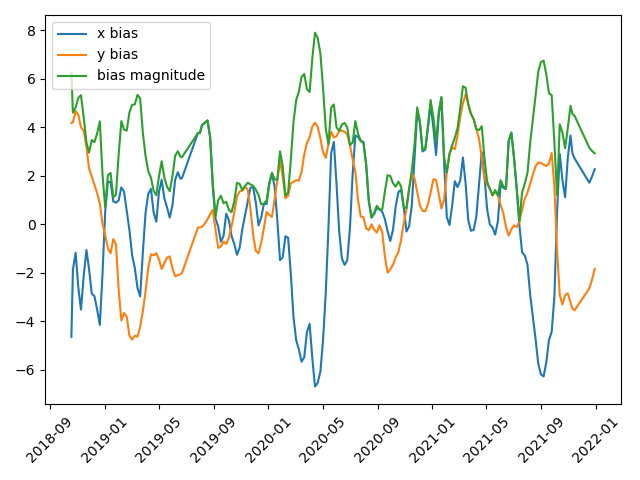

In [21]:
plt.figure()
plt.plot(df['time'], df['x_bias'], label='x bias')
plt.plot(df['time'], df['y_bias'], label='y bias')
plt.plot(df['time'], np.abs(df['x_bias']+1j*df['y_bias']), label='bias magnitude')
plt.legend()
[ii.set_rotation(45) for ii in plt.gca().xaxis.get_ticklabels()]
plt.tight_layout()

In [19]:
[ii.set_rotation(45) for ii in plt.gca().xaxis.get_ticklabels()]

[None, None, None, None, None, None, None, None, None, None, None]